In [1]:
# Import necessary Python libraries
import hashlib
import time
from collections import defaultdict
import random
import json
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# Define classes for managing transactions and blocks
class Transaction:
    def __init__(self, sender, recipient, amount):
        self.sender = sender
        self.recipient = recipient
        self.amount = amount
    
    def to_dict(self):
        return {
            'sender': self.sender,
            'recipient': self.recipient,
            'amount': self.amount,
        }

        
class Block:
    def __init__(self, index, previous_hash, transactions, timestamp, proof):
        self.index = index
        self.previous_hash = previous_hash
        self.transactions = transactions
        self.timestamp = timestamp
        self.proof = proof

    def calculate_hash(self):
        return hashlib.sha256(f"{self.index}{self.previous_hash}{self.transactions}{self.timestamp}{self.proof}".encode()).hexdigest()


In [7]:
# Define a Blockchain class for managing blockchain system.
class Blockchain:
    def __init__(self):
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    @staticmethod
    def hash(block):
        return block.calculate_hash()

    def last_block(self):
        return self.chain[-1] if self.chain else None


In [39]:
# Define a Proof-of-Work consensus mechanism and transaction verification function.
class PoWConsensus:
    @staticmethod
    def proof_of_work(last_proof, difficulty=6):
        proof = 0
        while PoWConsensus.validate_proof(last_proof, proof, difficulty) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, difficulty=6):
        guess = f"{last_proof}{proof}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:difficulty] == "0" * difficulty


def verify_transaction(transaction):
    if 'sender' not in transaction or 'recipient' not in transaction or 'amount' not in transaction:
        return False  

    sender = transaction['sender']
    recipient = transaction['recipient']
    amount = transaction['amount']

    return True  

In [40]:
class PoSConsensus:
    def __init__(self):
        self.validators = []
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_validator(self, validator):
        self.validators.append(validator)

    def select_validator(self):
        return random.choice(self.validators)

    def proof_of_stake(self, last_block):
        validator = self.select_validator()
        proof = 0
        while self.validate_proof(last_block.proof, proof, validator) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, validator):
        guess = f"{last_proof}{proof}{validator}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

In [41]:

class DPoSConsensus:
    def __init__(self):
        self.delegates = []
        self.chain = []
        self.current_transactions = []
        self.votes = {}  
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_delegate(self, delegate):
        self.delegates.append(delegate)
        self.votes[delegate] = []  

    def select_delegate(self):
        return random.choice(self.delegates)

    def delegated_proof_of_stake(self, last_block):
        delegate = self.select_delegate()
        proof = 0
        while self.validate_proof(last_block.proof, proof, delegate) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, delegate):
        guess = f"{last_proof}{proof}{delegate}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

    def vote(self, delegate, voter):
        if delegate in self.delegates and voter in self.delegates:
            self.votes[delegate].append(voter)

    def get_vote_count(self, delegate):
        return len(self.votes.get(delegate, []))


In [42]:
class RaftNode:
    def __init__(self, node_id, total_nodes):
        self.node_id = node_id
        self.total_nodes = total_nodes
        self.current_term = 0
        self.voted_for = None
        self.log = []
        self.commit_index = 0
        self.last_applied = 0
        self.state = "follower"
        self.leader_id = None
        self.timeout = random.randint(150, 300) / 1000.0  
        self.votes_received = defaultdict(lambda: False)
        self.last_heartbeat = time.time()  

    def become_follower(self, term, leader_id):
        self.state = "follower"
        self.current_term = term
        self.voted_for = None
        self.leader_id = leader_id

    def become_candidate(self):
        self.state = "candidate"
        self.current_term += 1
        self.voted_for = self.node_id
        self.votes_received = defaultdict(lambda: False)
   

    def become_leader(self):
        self.state = "leader"
        self.leader_id = self.node_id

    def request_vote(self, term, candidate_id, last_log_index, last_log_term):
        if term < self.current_term:
            return False

        if term > self.current_term:
            self.become_follower(term, None)

        if self.voted_for is None or self.voted_for == candidate_id:
            
            if last_log_term > self.log[-1]["term"] or (
                last_log_term == self.log[-1]["term"] and last_log_index >= len(self.log)
            ):
                self.voted_for = candidate_id
                return True

        return False

    def append_entries(self, term, leader_id, prev_log_index, prev_log_term, entries, leader_commit):
        if term < self.current_term:
            return False

        if term >= self.current_term:
            self.become_follower(term, leader_id)

        if prev_log_index >= len(self.log) or self.log[prev_log_index]["term"] != prev_log_term:
            return False

        self.log = self.log[: prev_log_index + 1] + entries
        if leader_commit > self.commit_index:
            self.commit_index = min(leader_commit, len(self.log) - 1)

        return True

    def send_heartbeat(self):
        
        pass
   
    def update_election_timeout(self):
        self.timeout = random.randint(150, 300) / 1000.0

    def simulate(self,max_duration_seconds):
        start_time = time.time()
        while time.time() - start_time < max_duration_seconds:
            if self.state == "follower":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout() 
                    self.become_candidate()
            elif self.state == "candidate":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout()  
                    self.become_candidate()

                    
                    votes = 1  
                    for node_id in range(self.total_nodes):
                        if node_id != self.node_id:
                            if self.log and self.request_vote(self.current_term, node_id, len(self.log) - 1, self.log[-1]["term"]):
                                votes += 1
                                if votes > self.total_nodes / 2:
                                    self.become_leader()
                                    break
            elif self.state == "leader":
                if time.time() - self.last_heartbeat > 0.1:
                    self.send_heartbeats()  
                    self.last_heartbeat = time.time()  
                    self.update_commit_index()  
            time.sleep(0.1)  

  
    def process_transaction(self):
        
        self.transaction_processing_time = random.uniform(0.001, 0.005)  
        time.sleep(self.transaction_processing_time)
            
def find_initial_leader(nodes):
    
    for node in nodes:
        if node.state == "leader":
            return node
    return None

In [43]:
def simulate_pow_throughputs():
    blockchain_pow = Blockchain()
    num_transactions_pow = [100, 500, 1000, 1500, 2000]
    throughputs_pow = {}

    for num_tx in num_transactions_pow:
        start_time = time.time()
        for _ in range(num_tx):
            sender = "Arafat"
            recipient = "Chopra"
            amount = 1

            if verify_transaction({"sender": sender, "recipient": recipient, "amount": amount}):
                blockchain_pow.add_transaction(sender, recipient, amount)
            else:
                print("Invalid transaction:", {"sender": sender, "recipient": recipient, "amount": amount})

        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        
        
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow, difficulty=6)
        
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        if end_time != start_time:
            throughput_pow = num_tx / (end_time - start_time)
            throughputs_pow[num_tx] = throughput_pow
        else:
            print("Zero time difference, throughput not calculated for", num_tx, "transactions")

        print(throughputs_pow)
    visualize_pow_throughput(throughputs_pow)


In [153]:
def simulate_pos_throughputs():
    blockchain_pos = PoSConsensus()
    validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_4", "Validator_5"]
    for address in validator_addresses:
        blockchain_pos.add_validator(address)

    num_transactions_pos = [100, 200,300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pos = {}
    pos_latencies = {}

    for num_tx in num_transactions_pos:
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Arafat", "Chopra", 5)
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="00", recipient="MinerAddress", amount=5)
        
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        time_taken = end_time - start_time
        throughput_pos = num_tx / time_taken
        throughputs_pos[num_tx] = throughput_pos
        pos_latencies[num_tx] = time_taken / num_tx
    visualize_pos_throughput(throughputs_pos)


In [57]:
def simulate_dpos_throughputs():
    blockchain_dpos = DPoSConsensus()
    delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]  
    for address in delegate_addresses:
        blockchain_dpos.add_delegate(address)

    num_transactions_dpos = [100, 500, 1000, 1500, 2000]
    throughputs_dpos = {}

    for num_tx in num_transactions_dpos:
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_dpos.add_transaction("Arafat", "Chopra", 1)
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        
        time_taken = end_time - start_time
        throughput_dpos = num_tx / time_taken
        throughputs_dpos[num_tx] = throughput_dpos
        print(throughputs_dpos)
    visualize_dpos_throughput(throughputs_dpos)


In [46]:
def simulate_raft_throughputs():
    num_nodes = 5
    num_transactions_list = [100, 500, 1000, 1500, 2000]  
    initial_leader_node_id = 0  
    max_duration_seconds = 5  
    
    nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]

    throughputs = {}

    for num_tx in num_transactions_list:
        start_time = time.time()
        print(f"Starting transaction loop for {num_tx} transactions...")

        
        for node in nodes:
            node.state = "follower"
        
        
        initial_leader = nodes[initial_leader_node_id]
        initial_leader.become_leader()

       
        transactions_processed = 0

        while transactions_processed < num_tx:
            leader_node = find_initial_leader(nodes)

            if leader_node is not None:
                leader_node.process_transaction()
                transactions_processed += 1

        end_time = time.time()
        print(f"Transaction loop for {num_tx} transactions completed in {end_time - start_time:.2f} seconds.")

        time_taken = end_time - start_time
        if time_taken > 0:
            throughput = num_tx / time_taken
            throughputs[num_tx] = throughput

    visualize_raft_throughput(throughputs)


In [63]:
def simulate_latency_impact():
    num_transactions = [100, 500, 1000, 1500, 2000]
    num_nodes = 5  
    max_duration_seconds = 5  
    pow_latencies = {}
    pos_latencies = {}
    dpos_latencies = {}
    raft_latencies = {}

    for num_tx in num_transactions:
        # PoW simulation
        blockchain_pow = Blockchain()
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pow.add_transaction("Aarafat", "Chopra", 1)
        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow)
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        pow_latencies[num_tx] = (end_time - start_time) / num_tx

        # PoS simulation
        blockchain_pos = PoSConsensus()
        validator_addresses = ["Validator1", "Validator2", "Validator3"] 
        for address in validator_addresses:
            blockchain_pos.add_validator(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Aarafat", "Chopra", 1)
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        
        
        # DPoS simulation
        blockchain_dpos = DPoSConsensus()
        delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]
        for address in delegate_addresses:
            blockchain_dpos.add_delegate(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_dpos.add_transaction("Aarafat", "Chopra", 1)
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        dpos_latencies[num_tx] = (end_time - start_time) / num_tx
        

        # raft
        nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]
        start_time = time.time()

        for node in nodes:
            node.simulate(max_duration_seconds)

        end_time = time.time()
        latency = (end_time - start_time) / num_tx
        raft_latencies[num_tx] = latency

    

        

    print("pow_latencies:",pow_latencies)
    print("pos_latencies:",pos_latencies)
    print("dpos_latencies:",dpos_latencies)
    print("raft_latencies:",raft_latencies)
    visualize_PoW_latency_impact(pow_latencies)
    visualize_PoS_latency_impact(pos_latencies)
    visualize_dpos_latency_impact(dpos_latencies)
    visualize_raft_latency_impact(raft_latencies)
    
    visualize_latency_comparison(pow_latencies, pos_latencies,dpos_latencies,raft_latencies)


In [65]:

def simulate_latency_with_nodes_pow(num_nodes):
    
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = Blockchain()
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        last_proof_nodes = last_block_nodes.proof
        proof_nodes = PoWConsensus.proof_of_work(last_proof_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000 
    return latencies

def simulate_latency_with_nodes_pos(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = PoSConsensus()
        validator_addresses = ["Validator1", "Validator2", "Validator3"]
        for address in validator_addresses:
            blockchain_nodes.add_validator(address)
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  
    return latencies


def simulate_latency_with_nodes_dpos(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = DPoSConsensus()
        delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]
        for address in delegate_addresses:
            blockchain_nodes.add_delegate(address)
        start_time = time.time()
        for _ in range(1000):  
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.delegated_proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  
    return latencies

def simulate_latency_with_nodes_raft(num_nodes):
   
    latencies = {}
    for num_n in num_nodes:
        nodes = [RaftNode(node_id, num_n) for node_id in range(num_n)]
        start_time = time.time()

        print(f"Simulating Raft with {num_n} nodes...")

        
        for node in nodes:
            node.simulate(max_duration_seconds=5)

        end_time = time.time()
        elapsed_time = end_time - start_time
        latencies[num_n] = elapsed_time / 1000  
        
        print(f"Simulation with {num_n} nodes completed in {elapsed_time:.2f} seconds.")
    return latencies



In [113]:

def visualize_pow_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Proof of Work)')
    plt.grid(True)
    plt.show()

def visualize_pos_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)')
    plt.grid(True)
    plt.savefig('Average Throughput with Varying Numbers of Transactions (Proof of Stake).png', dpi=300, bbox_inches='tight')
    plt.show()
    
def visualize_dpos_throughput(throughputs_dpos):
    plt.plot(throughputs_dpos.keys(), throughputs_dpos.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (DPoS)')
    plt.grid(True)
    plt.show()

def visualize_raft_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Raft)')
    plt.grid(True)
    plt.show()

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pos_throughput(throughputs):
    sns.set(style="darkgrid")

    fig, ax = plt.subplots(figsize=(8, 5))

    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='o', ax=ax, markersize=8, color='skyblue')

    ax.set_xlabel('Number of Transactions', fontsize=14)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=14)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)', fontsize=16)

    
    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig('Average_Throughput_Pos.png', dpi=300)
    plt.show()



In [122]:
def visualize_PoW_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoW)')
    plt.grid(True)
    plt.show()
    
def visualize_PoS_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoS)')
    plt.grid(True)
    plt.show()

def visualize_dpos_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (DPoS)')
    plt.grid(True)
    plt.show()

    
def visualize_raft_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (Raft)')
    plt.grid(True)
    plt.show()

In [50]:
   
def visualize_latency_comparison(pow_latencies, pos_latencies, dpos_latencies, raft_latencies):
    num_transactions = list(pow_latencies.keys())
    pow_latency_values = list(pow_latencies.values())
    pos_latency_values = list(pos_latencies.values())
    dpos_latency_values = list(dpos_latencies.values())
    raft_latency_values = list(raft_latencies.values())

    width = 100
    fig, ax = plt.subplots()
    bar1 = ax.bar([num - 1.5 * width for num in num_transactions], pow_latency_values, width,
                  label='PoW Latency', color='skyblue', edgecolor='none', linewidth=2)
    bar2 = ax.bar([num - 0.5 * width for num in num_transactions], pos_latency_values, width,
                  label='PoS Latency', color='lightcoral', edgecolor='none', linewidth=2)
    bar3 = ax.bar([num + 0.5 * width for num in num_transactions], dpos_latency_values, width,
                  label='DPoS Latency', color='lightgreen', edgecolor='none', linewidth=2)
    bar4 = ax.bar([num + 1.5 * width for num in num_transactions], raft_latency_values, width,
                  label='Raft Latency', color='lightyellow', edgecolor='none', linewidth=2)

    ax.set_xlabel('Number of Transactions')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Comparison of Average Latency (PoW vs. PoS vs. DPoS vs. Raft)')
    ax.set_xticks(num_transactions)
    ax.legend()
    ax.grid(True)

    plt.show()


In [66]:
def visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes):
    num_nodes_pow = list(pow_latencies.keys())
    pow_latency_values = [pow_latencies[num_n] for num_n in num_nodes_pow]
    
    num_nodes_pos = list(pos_latencies.keys())
    pos_latency_values = [pos_latencies[num_n] for num_n in num_nodes_pos]
    
    num_nodes_dpos = list(dpos_latencies.keys())
    dpos_latency_values = [dpos_latencies[num_n] for num_n in num_nodes_dpos]

    num_nodes_raft = list(raft_latencies.keys())
    raft_latency_values = [raft_latencies[num_n] for num_n in num_nodes_raft]

    width = 1.3
    fig, ax = plt.subplots()
    
    bar1 = ax.bar([num - width for num in num_nodes_pow], pow_latency_values, width,
                  label='PoW Latency', color='royalblue', edgecolor='none', linewidth=0.1)
    
    bar2 = ax.bar(num_nodes_pos, pos_latency_values, width,
                  label='PoS Latency', color='orange', edgecolor='none', linewidth=0.1)
    
    bar3 = ax.bar([num + width for num in num_nodes_dpos], dpos_latency_values, width,
                  label='DPoS Latency', color='green', edgecolor='none', linewidth=0.1)
    
    bar4 = ax.bar([num + 2*width for num in num_nodes_raft], raft_latency_values, width,
                  label='Raft Latency', color='purple', edgecolor='none', linewidth=0.1)

    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Average Latency with Varying Numbers of Nodes')
    ax.set_xticks(num_nodes_pow + num_nodes_pos + num_nodes_dpos + num_nodes_raft)
    ax.legend()
    ax.grid(True)

    plt.show()


In [195]:
def simulate_pow_throughputs():
    blockchain_pow = Blockchain()
    num_transactions_pow = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pow = {}

    for num_tx in num_transactions_pow:
        start_time = time.time()
        for _ in range(num_tx):
            sender = "Arafat"
            recipient = "Chopra"
            amount = 1

            if verify_transaction({"sender": sender, "recipient": recipient, "amount": amount}):
                blockchain_pow.add_transaction(sender, recipient, amount)
            else:
                print("Invalid transaction:", {"sender": sender, "recipient": recipient, "amount": amount})

        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow, difficulty=6)
        
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        if end_time != start_time:
            throughput_pow = num_tx / (end_time - start_time)
            throughputs_pow[num_tx] = throughput_pow
        else:
            print("Zero time difference, throughput not calculated for", num_tx, "transactions")

        print(throughputs_pow)
    return throughputs_pow


In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pow_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    fig, ax = plt.subplots(figsize=(9, 6))

    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (PoW)', fontsize=16)

    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_PoW.png', dpi=300)
    plt.show()




In [197]:
throughputs_pow = simulate_pow_throughputs()
print("throughputs_pow : ", throughputs_pow)

{100: 16.960422483668587}
{100: 16.960422483668587, 200: 3.1761860800875583}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505, 500: 48.31471393415387}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264, 700: 8.747533338935781}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264, 700: 8.747533338935781, 800: 8.597846547746798}
{100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903, 400: 37.288830019955505, 5

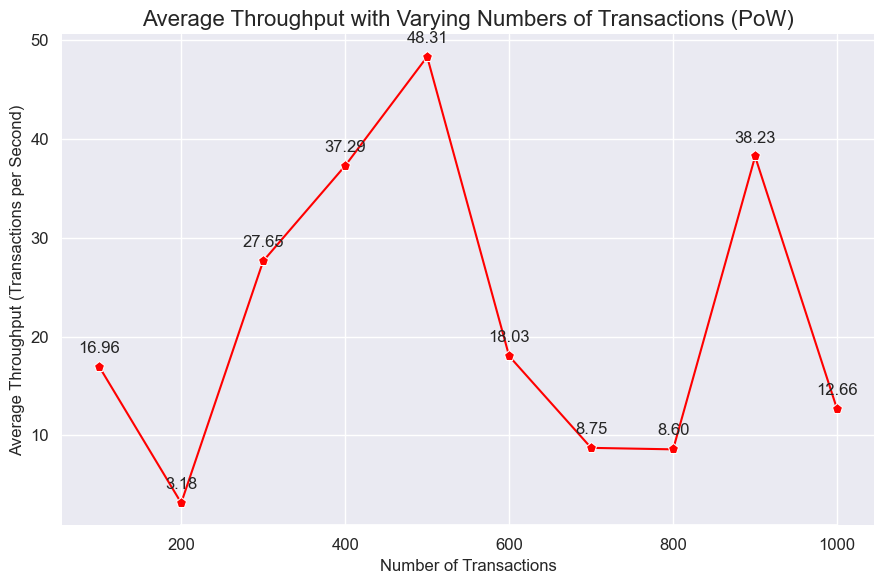

In [217]:
visualize_pow_throughput(throughputs_pow)

In [181]:
import time  

def simulate_pos_throughputs():
    blockchain_pos = PoSConsensus()
    validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_4", "Validator_5"]
    for address in validator_addresses:
        blockchain_pos.add_validator(address)

    num_transactions_pos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pos = {}
    pos_latencies = {}

    for num_tx in num_transactions_pos:
        start_time = time.time()
        

        transaction_delay = 0.00001  
        
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Arafat", "Chopra", 5)
            time.sleep(transaction_delay)  
            
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="00", recipient="MinerAddress", amount=5)

        
        block_creation_delay = 1  
        time.sleep(block_creation_delay) 

        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx

        
        time_taken = end_time - start_time
        throughput_pos = num_tx / time_taken
        throughputs_pos[num_tx] = throughput_pos

      
        pos_latencies[num_tx] = time_taken / num_tx


    return throughputs_pos


In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pos_throughput(throughputs):

    sns.set(style="darkgrid")


    fig, ax = plt.subplots(figsize=(9, 6))


    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

   
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)', fontsize=16)


    ax.grid(True)

    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_Pos.png', dpi=300)
    plt.show()


In [186]:
throughputs_pos = simulate_pos_throughputs()
print("throughputs PoS :",throughputs_pos)


throughputs PoS : {100: 33.50740368877473, 200: 47.67022957052793, 300: 52.19339257640757, 400: 54.33477035620927, 500: 56.019078122091315, 600: 57.303775435758574, 700: 57.78015326118836, 800: 58.97753562040681, 900: 57.441280073780504, 1000: 58.56965642812293}


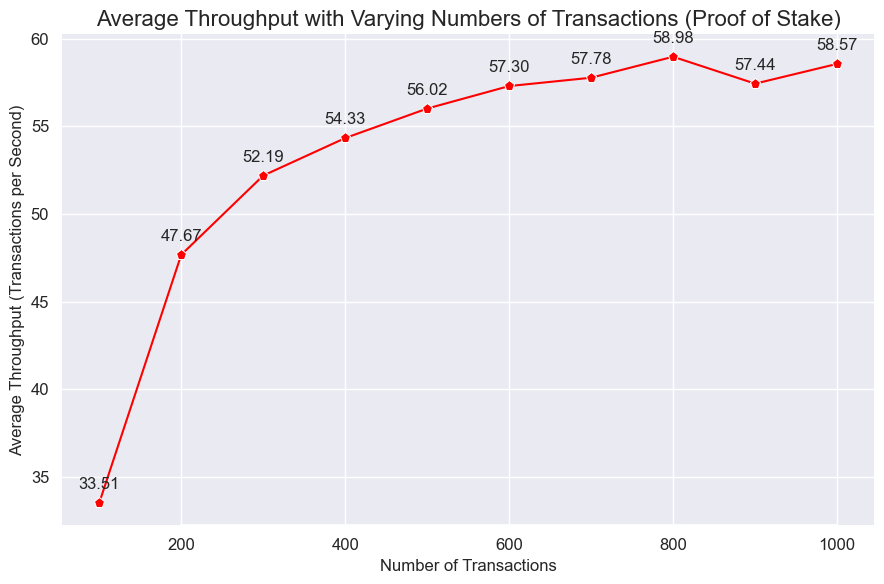

In [219]:
visualize_pos_throughput(throughputs_pos)

In [188]:
import time
import random  

def simulate_dpos_throughputs():
    blockchain_dpos = DPoSConsensus()
    delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]  
    for address in delegate_addresses:
        blockchain_dpos.add_delegate(address)

    num_transactions_dpos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_dpos = {}

    for num_tx in num_transactions_dpos:
        start_time = time.time()
        for _ in range(num_tx):
          
            time.sleep(random.uniform(0.00001, 0.00005))
            blockchain_dpos.add_transaction("Arafat", "Chopra", 1)

       
        time.sleep(random.uniform(0.1, 0.5))
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        
        time_taken = end_time - start_time
        throughput_dpos = num_tx / time_taken
        throughputs_dpos[num_tx] = throughput_dpos
        print(throughputs_dpos)

    return throughputs_dpos



In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_dpos_throughput(throughputs):

    sns.set(style="darkgrid")


    fig, ax = plt.subplots(figsize=(9, 6))


    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')


    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (DPoS)', fontsize=16)


    ax.grid(True)


    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig('Average_Throughput_DPoS.png', dpi=300)
    plt.show()



In [189]:
throughputs_dpos = simulate_dpos_throughputs()

{100: 49.37953937432629}
{100: 49.37953937432629, 200: 57.95205057186542}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924, 700: 60.69523525461582}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924, 700: 60.69523525461582, 800: 60.835073098416714}
{100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005

In [224]:
print("throughputs_dpos: ", throughputs_dpos)

throughputs_dpos:  {100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698, 400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924, 700: 60.69523525461582, 800: 60.835073098416714, 900: 60.663356002475275, 1000: 61.35689915052454}


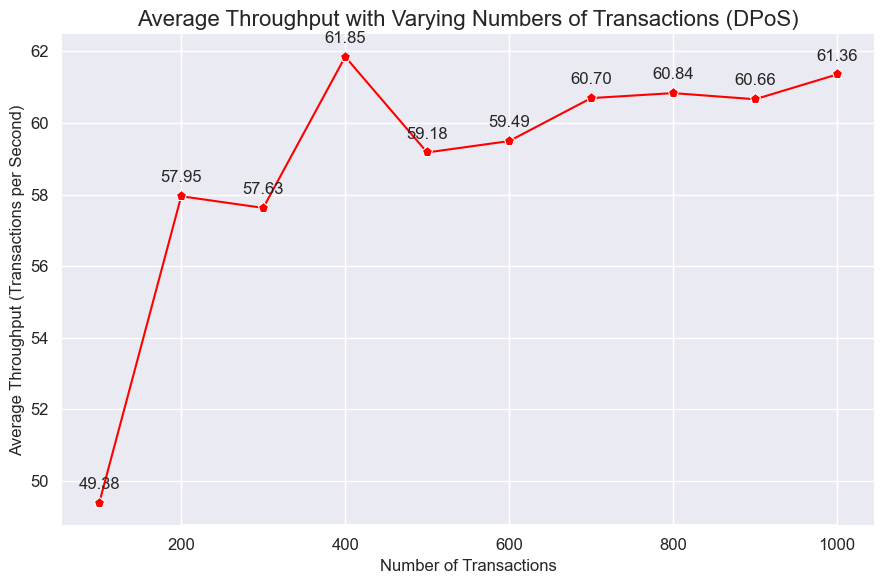

In [221]:
visualize_dpos_throughput(throughputs_dpos)

In [204]:
def simulate_raft_throughputs():
    num_nodes = 5
    num_transactions_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] 
    initial_leader_node_id = 0  
    max_duration_seconds = 5  
    
    nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]

    throughputs = {}

    for num_tx in num_transactions_list:
        start_time = time.time()
        print(f"Starting transaction loop for {num_tx} transactions...")


        for node in nodes:
            node.state = "follower"
        
        
        initial_leader = nodes[initial_leader_node_id]
        initial_leader.become_leader()


        transactions_processed = 0

        while transactions_processed < num_tx:
            leader_node = find_initial_leader(nodes)

            if leader_node is not None:
                leader_node.process_transaction()
                transactions_processed += 1

        end_time = time.time()
        print(f"Transaction loop for {num_tx} transactions completed in {end_time - start_time:.2f} seconds.")

        time_taken = end_time - start_time
        if time_taken > 0:
            throughput = num_tx / time_taken
            throughputs[num_tx] = throughput
            print(throughputs)

    return throughputs


In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_raft_throughput(throughputs):

    sns.set(style="darkgrid")


    fig, ax = plt.subplots(figsize=(9, 6))


    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')


    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Raft)', fontsize=16)


    ax.grid(True)


    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

  
    plt.tight_layout()
    plt.savefig('Average_Throughput_raft.png', dpi=300)
    plt.show()



In [206]:
raft_throughputs = simulate_raft_throughputs()
print("raft_throughputs : ", raft_throughputs)

Starting transaction loop for 100 transactions...
Transaction loop for 100 transactions completed in 1.60 seconds.
{100: 62.424369517148115}
Starting transaction loop for 200 transactions...
Transaction loop for 200 transactions completed in 3.20 seconds.
{100: 62.424369517148115, 200: 62.43240700716507}
Starting transaction loop for 300 transactions...
Transaction loop for 300 transactions completed in 4.79 seconds.
{100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171}
Starting transaction loop for 400 transactions...
Transaction loop for 400 transactions completed in 6.36 seconds.
{100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171, 400: 62.90128153946702}
Starting transaction loop for 500 transactions...
Transaction loop for 500 transactions completed in 7.86 seconds.
{100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171, 400: 62.90128153946702, 500: 63.58697766378971}
Starting transaction loop for 600 transactions...
Trans

In [209]:
print("raft_throughputs : ", raft_throughputs)

raft_throughputs :  {100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171, 400: 62.90128153946702, 500: 63.58697766378971, 600: 63.4389431319818, 700: 62.631345529184564, 800: 62.72215313104176, 900: 62.71578753771484, 1000: 62.88832110578503}


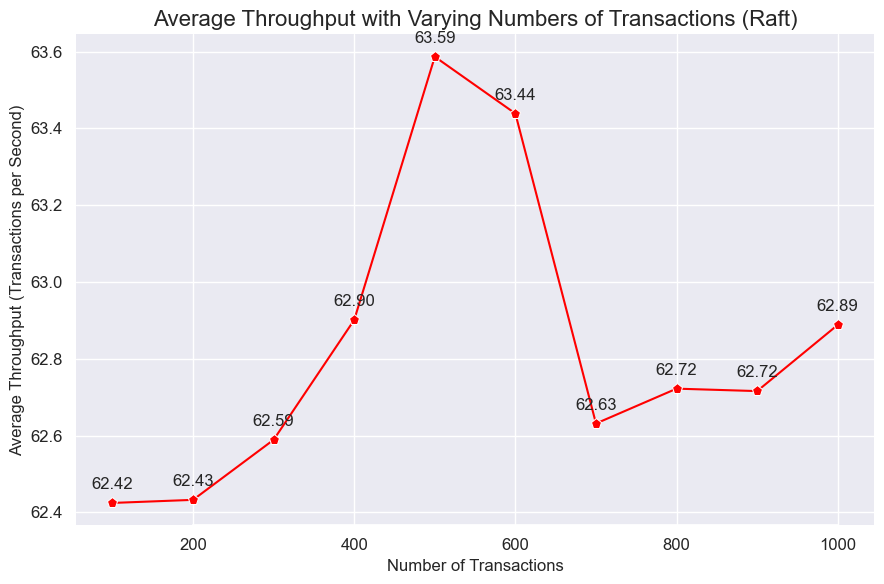

In [223]:
visualize_raft_throughput(raft_throughputs)

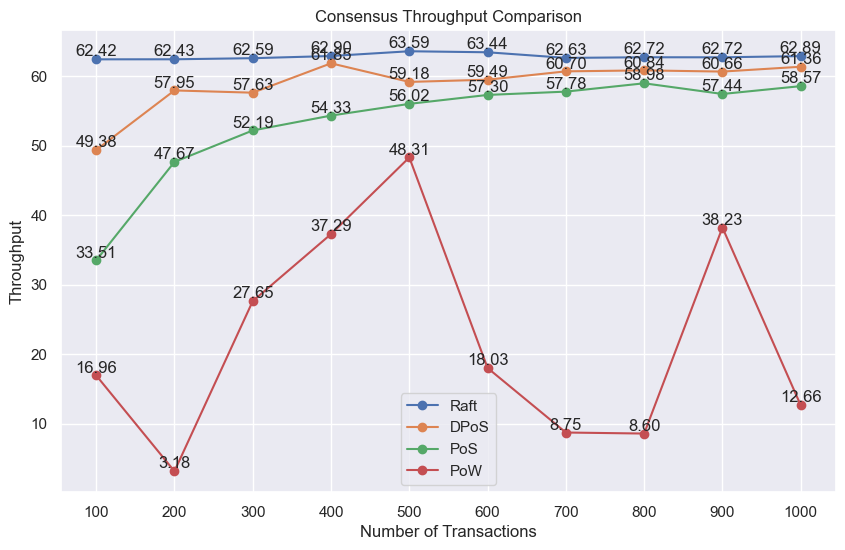

In [225]:
import matplotlib.pyplot as plt

raft_throughputs = {
    100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171,
    400: 62.90128153946702, 500: 63.58697766378971, 600: 63.4389431319818,
    700: 62.631345529184564, 800: 62.72215313104176, 900: 62.71578753771484,
    1000: 62.88832110578503
}

throughputs_dpos = {
    100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698,
    400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924,
    700: 60.69523525461582, 800: 60.835073098416714, 900: 60.663356002475275,
    1000: 61.35689915052454
}

throughputs_pos = {
    100: 33.50740368877473, 200: 47.67022957052793, 300: 52.19339257640757,
    400: 54.33477035620927, 500: 56.019078122091315, 600: 57.303775435758574,
    700: 57.78015326118836, 800: 58.97753562040681, 900: 57.441280073780504,
    1000: 58.56965642812293
}

throughputs_pow = {
    100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903,
    400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264,
    700: 8.747533338935781, 800: 8.597846547746798, 900: 38.22638925982949,
    1000: 12.66473959172757
}


x = list(raft_throughputs.keys())
raft_y = list(raft_throughputs.values())
dpos_y = list(throughputs_dpos.values())
pos_y = list(throughputs_pos.values())
pow_y = list(throughputs_pow.values())


plt.figure(figsize=(10, 6))
plt.plot(x, raft_y, marker='o', label='Raft')
plt.plot(x, dpos_y, marker='o', label='DPoS')
plt.plot(x, pos_y, marker='o', label='PoS')
plt.plot(x, pow_y, marker='o', label='PoW')


plt.xlabel('Number of Transactions')
plt.ylabel('Throughput')
plt.title('Consensus Throughput Comparison')
plt.xticks(x)


plt.legend()


for i in range(len(x)):
    plt.text(x[i], raft_y[i], f'{raft_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], dpos_y[i], f'{dpos_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], pos_y[i], f'{pos_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], pow_y[i], f'{pow_y[i]:.2f}', ha='center', va='bottom')


plt.grid(True)
plt.show()


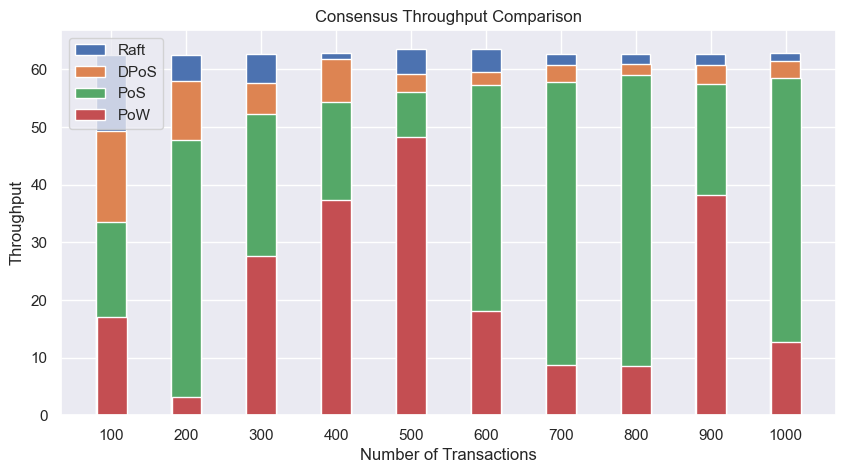

In [231]:
import matplotlib.pyplot as plt


raft_throughputs = {
    100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171,
    400: 62.90128153946702, 500: 63.58697766378971, 600: 63.4389431319818,
    700: 62.631345529184564, 800: 62.72215313104176, 900: 62.71578753771484,
    1000: 62.88832110578503
}

throughputs_dpos = {
    100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698,
    400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924,
    700: 60.69523525461582, 800: 60.835073098416714, 900: 60.663356002475275,
    1000: 61.35689915052454
}

throughputs_pos = {
    100: 33.50740368877473, 200: 47.67022957052793, 300: 52.19339257640757,
    400: 54.33477035620927, 500: 56.019078122091315, 600: 57.303775435758574,
    700: 57.78015326118836, 800: 58.97753562040681, 900: 57.441280073780504,
    1000: 58.56965642812293
}

throughputs_pow = {
    100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903,
    400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264,
    700: 8.747533338935781, 800: 8.597846547746798, 900: 38.22638925982949,
    1000: 12.66473959172757
}


x = list(raft_throughputs.keys())
raft_y = list(raft_throughputs.values())
dpos_y = list(throughputs_dpos.values())
pos_y = list(throughputs_pos.values())
pow_y = list(throughputs_pow.values())


plt.figure(figsize=(10, 5))
plt.bar(x, raft_y, width= 40, label='Raft')
plt.bar([num + 0.2 for num in x], dpos_y, width=40, label='DPoS')
plt.bar([num + 0.4 for num in x], pos_y, width=40, label='PoS')
plt.bar([num + 0.6 for num in x], pow_y, width=40, label='PoW')


plt.xlabel('Number of Transactions')
plt.ylabel('Throughput')
plt.title('Consensus Throughput Comparison')
plt.xticks([num + 0.3 for num in x], x)


plt.legend()

# Display values on data points
#for i in range(len(x)):
   # plt.text(x[i], raft_y[i], f'{raft_y[i]:.2f}', ha='center', va='bottom')
   # plt.text(x[i] + 0.2, dpos_y[i], f'{dpos_y[i]:.2f}', ha='center', va='bottom')
   # plt.text(x[i] + 0.4, pos_y[i], f'{pos_y[i]:.2f}', ha='center', va='bottom')
    #plt.text(x[i] + 0.6, pow_y[i], f'{pow_y[i]:.2f}', ha='center', va='bottom')


plt.grid(True)
plt.show()


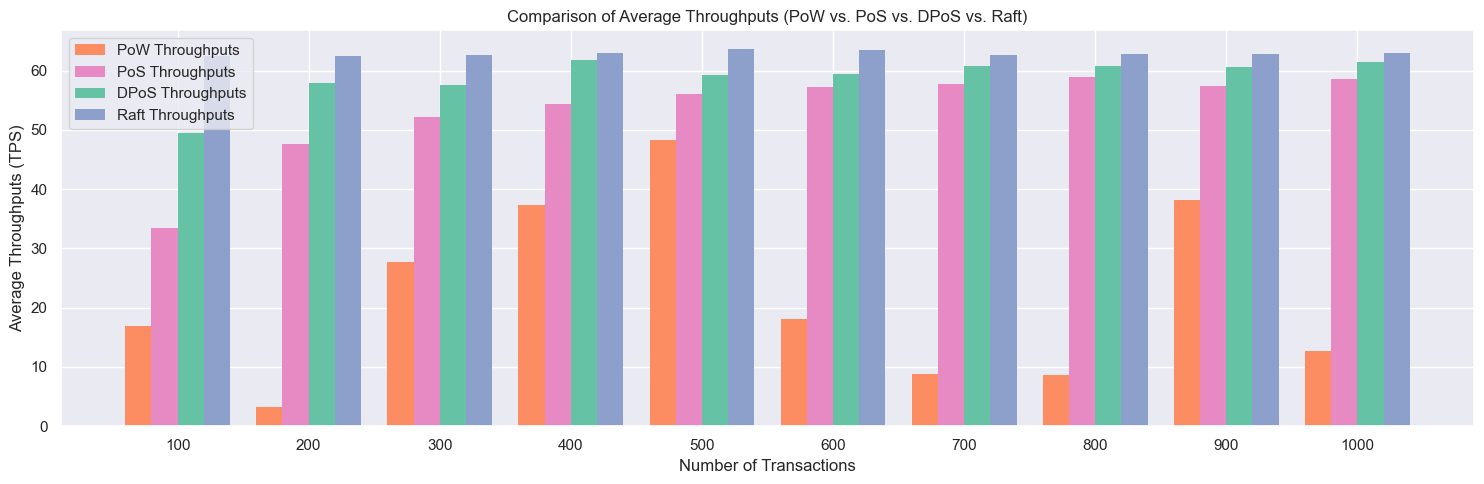

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


colors = sns.color_palette('Set2', n_colors=4)

num_transactions = list(throughputs_pow.keys())
pow_throughputs_values = list(throughputs_pow.values())
pos_throughputs_values = list(throughputs_pos.values())
dpos_throughputs_values = list(throughputs_dpos.values())
raft_throughputs_values = list(raft_throughputs.values())


width = 0.2
fig, ax = plt.subplots(figsize=(15, 5))


x = np.arange(len(num_transactions))

# Create grouped bars
#bar1 = ax.bar(x - width, pow_throughputs_values, width, label='PoW Throughputs', color='slateblue', edgecolor='none', linewidth=0.7)
#bar2 = ax.bar(x, pos_throughputs_values, width, label='PoS Throughputs', color='salmon', edgecolor='none', linewidth=0.7)
#bar3 = ax.bar(x + width, dpos_throughputs_values, width, label='DPoS Throughputs', color='lawngreen', edgecolor='none', linewidth=0.7)
#bar4 = ax.bar(x + (width*2), raft_throughputs_values, width, label='Raft Throughputs', color='mediumblue', edgecolor='none', linewidth=0.7)


bar1 = ax.bar(x - 1.5 * width, pow_throughputs_values, width, label='PoW Throughputs', color=colors[1], edgecolor='none', linewidth=0.7)
bar2 = ax.bar(x - 0.5 * width, pos_throughputs_values, width, label='PoS Throughputs', color=colors[3], edgecolor='none', linewidth=0.7)
bar3 = ax.bar(x + 0.5 * width, dpos_throughputs_values, width, label='DPoS Throughputs', color=colors[0], edgecolor='none', linewidth=0.7)
bar4 = ax.bar(x + 1.5 * width, raft_throughputs_values, width, label='Raft Throughputs', color=colors[2], edgecolor='none', linewidth=0.7)


ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Average Throughputs (TPS)')
ax.set_title('Comparison of Average Throughputs (PoW vs. PoS vs. DPoS vs. Raft)')
ax.set_xticks(x)
ax.set_xticklabels(num_transactions)
ax.legend()
ax.grid(True)


def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

#add_values(bar1)
#add_values(bar2)
#add_values(bar3)
#add_values(bar4)

plt.tight_layout()
plt.savefig('Comparision of Average Throughput_pow_pos_dpos_raft.png', dpi=300)
plt.show()


pow_latencies: {100: 0.05609826564788818, 500: 0.011001351356506348, 1000: 0.006100424766540527, 1500: 0.005463244120279948, 2000: 0.002856880187988281}
pos_latencies: {100: 0.0009752297401428222, 500: 0.00017212533950805665, 1000: 0.00021230053901672363, 1500: 3.8379828135172524e-05, 2000: 4.717504978179932e-05}
dpos_latencies: {100: 0.0004251289367675781, 500: 0.00030452775955200194, 1000: 5.195856094360352e-05, 1500: 0.00011851803461710612, 2000: 1.5603303909301756e-05}
raft_latencies: {100: 0.2541941165924072, 500: 0.05058302164077759, 1000: 0.025314429998397826, 1500: 0.01681805372238159, 2000: 0.012651056766510009}


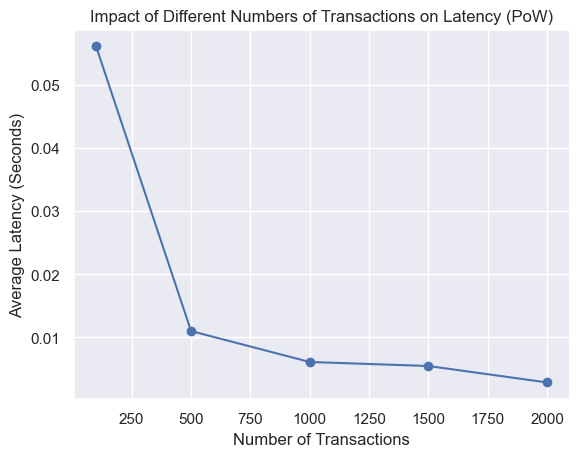

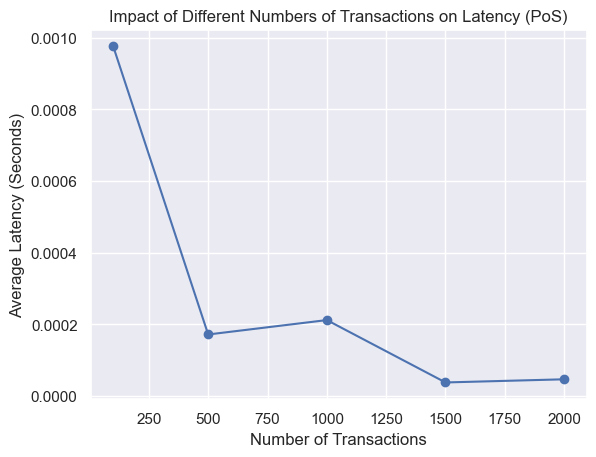

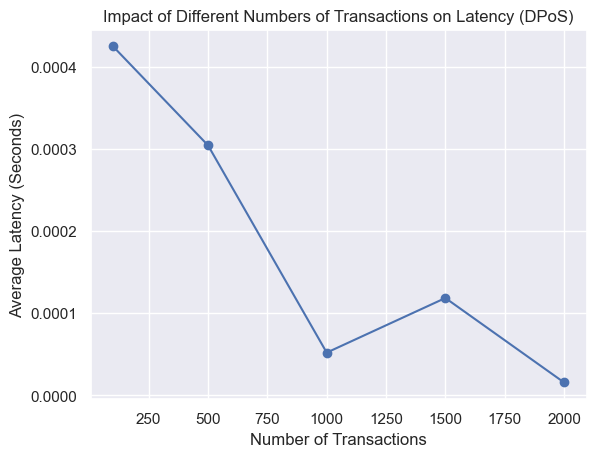

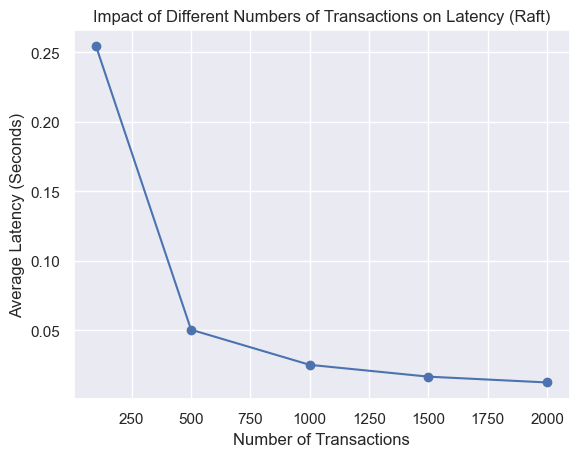

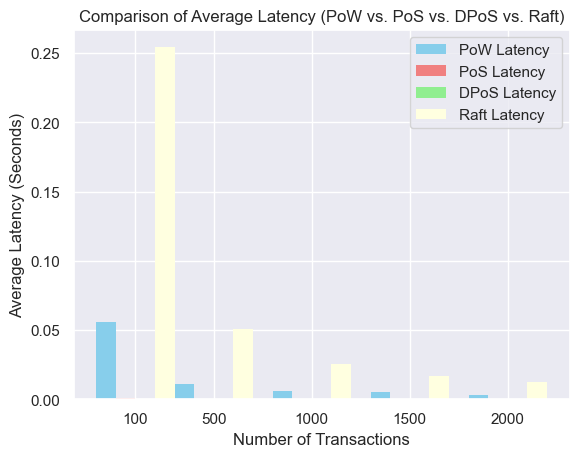

In [245]:
simulate_latency_impact()

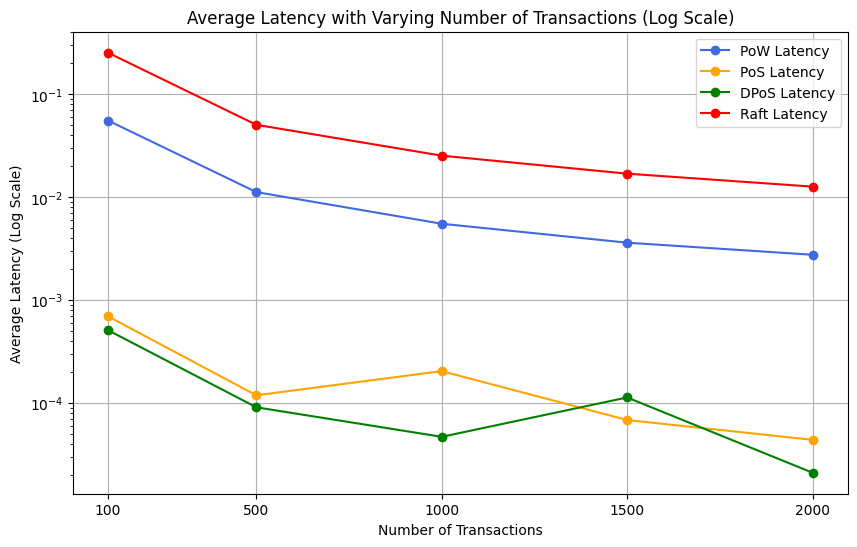

In [72]:
import matplotlib.pyplot as plt
import numpy as np


num_transactions = [100, 500, 1000, 1500, 2000]
pow_latencies = {100: 0.05560929536819458, 500: 0.011211042404174804, 1000: 0.005520173788070679, 1500: 0.003613100369771322, 2000: 0.0027570225000381468}
pos_latencies = {100: 0.0006953501701354981, 500: 0.00011875152587890625, 1000: 0.00020401740074157715, 1500: 6.831471125284831e-05, 2000: 4.3844223022460934e-05}
dpos_latencies = {100: 0.0005100798606872558, 500: 9.080696105957032e-05, 1000: 4.690051078796387e-05, 1500: 0.00011315504709879558, 2000: 2.0999431610107423e-05}
raft_latencies = {100: 0.25356934070587156, 500: 0.050534528732299806, 1000: 0.02533510112762451, 1500: 0.01693139664332072, 2000: 0.012669727802276612}


plt.figure(figsize=(10, 6))
plt.semilogy(num_transactions, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_transactions, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_transactions, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_transactions, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')


plt.xlabel('Number of Transactions')
plt.ylabel('Average Latency (Log Scale)')
plt.title('Average Latency with Varying Number of Transactions (Log Scale)')
plt.xticks(num_transactions)


plt.legend()


plt.grid(True)
plt.show()


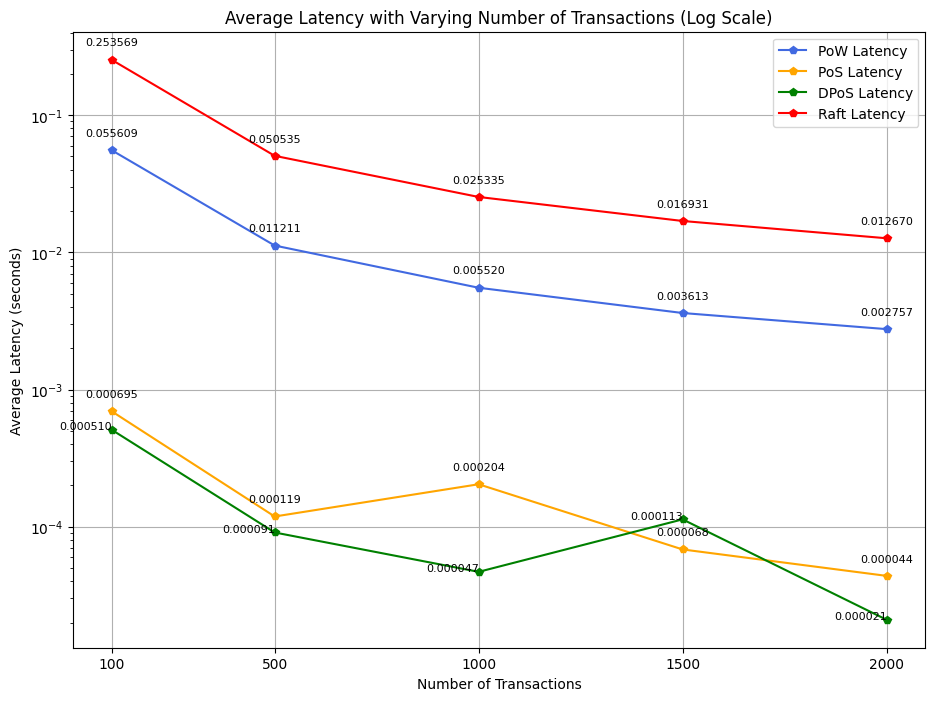

In [111]:
import matplotlib.pyplot as plt
import numpy as np


num_transactions = [100, 500, 1000, 1500, 2000]
pow_latencies = {100: 0.05560929536819458, 500: 0.011211042404174804, 1000: 0.005520173788070679, 1500: 0.003613100369771322, 2000: 0.0027570225000381468}
pos_latencies = {100: 0.0006953501701354981, 500: 0.00011875152587890625, 1000: 0.00020401740074157715, 1500: 6.831471125284831e-05, 2000: 4.3844223022460934e-05}
dpos_latencies = {100: 0.0005100798606872558, 500: 9.080696105957032e-05, 1000: 4.690051078796387e-05, 1500: 0.00011315504709879558, 2000: 2.0999431610107423e-05}
raft_latencies = {100: 0.25356934070587156, 500: 0.050534528732299806, 1000: 0.02533510112762451, 1500: 0.01693139664332072, 2000: 0.012669727802276612}


fig, ax = plt.subplots(figsize=(11, 8))
ax.set_yscale('log')



ax.plot(num_transactions, list(pow_latencies.values()), marker='p', label='PoW Latency', color='royalblue')
ax.plot(num_transactions, list(pos_latencies.values()), marker='p', label='PoS Latency', color='orange')
ax.plot(num_transactions, list(dpos_latencies.values()), marker='p', label='DPoS Latency', color='green')
ax.plot(num_transactions, list(raft_latencies.values()), marker='p', label='Raft Latency', color='red')

for tx, val in pow_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')
for tx, val in pos_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')
for tx, val in dpos_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 0), ha='right')
for tx, val in raft_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')


ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Average Latency (seconds)')
ax.set_title('Average Latency with Varying Number of Transactions (Log Scale)')


ax.set_xticks(num_transactions)


ax.legend()


plt.grid(True)
plt.savefig('Average Latency with Varying Number of Transactions Log Scale.png', dpi=300, bbox_inches='tight')
plt.show()


In [1]:

num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]

pow_latencies = simulate_latency_with_nodes_pow(num_nodes)
pos_latencies = simulate_latency_with_nodes_pos(num_nodes)
dpos_latencies = simulate_latency_with_nodes_dpos(num_nodes)
raft_latencies = simulate_latency_with_nodes_raft(num_nodes)
for num_n, latency in raft_latencies.items():
    print(f"Nodes: {num_n}, Average Latency: {latency:.4f} seconds")


NameError: name 'simulate_latency_with_nodes_pow' is not defined

In [69]:
print("pow_latencies:",pow_latencies)
print("pos_latencies:",pos_latencies)
print("dpos_latencies:",dpos_latencies)
print("raft_latencies:",raft_latencies)

pow_latencies: {5: 0.005546874523162841, 10: 0.005437691450119018, 15: 0.0055935182571411135, 20: 0.005513352155685425, 25: 0.00543338418006897, 30: 0.005386836051940918, 35: 0.005444554805755615, 40: 0.005507029056549072}
pos_latencies: {5: 3.8748741149902344e-05, 10: 0.0002198927402496338, 15: 0.00015687227249145508, 20: 4.741668701171875e-05, 25: 9.624767303466797e-05, 30: 8.193683624267578e-05, 35: 9.429550170898438e-05, 40: 4.693531990051269e-05}
dpos_latencies: {5: 4.838132858276367e-05, 10: 0.00015578937530517578, 15: 4.736018180847168e-05, 20: 0.000164034366607666, 25: 4.726099967956543e-05, 30: 4.6929121017456057e-05, 35: 4.7220230102539065e-05, 40: 0.00018793201446533204}
raft_latencies: {5: 0.02505048894882202, 10: 0.05028015375137329, 15: 0.07521603417396545, 20: 0.10030747056007386, 25: 0.12645335531234742, 30: 0.15181209754943847, 35: 0.17708705163002014, 40: 0.20250406694412232}


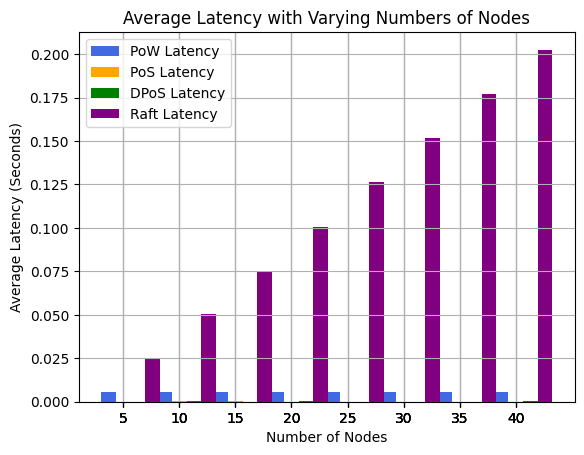

In [70]:
num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes)

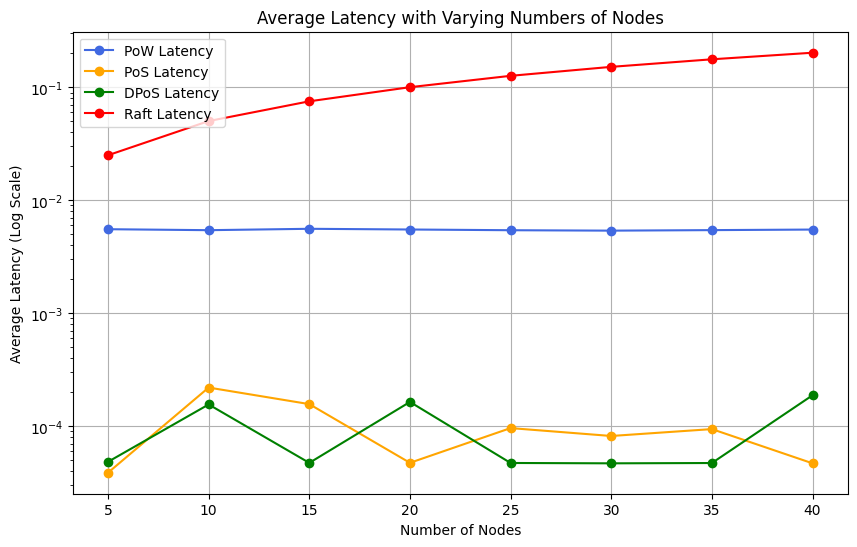

In [71]:
import matplotlib.pyplot as plt
import numpy as np


num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
pow_latencies = {5: 0.005546874523162841, 10: 0.005437691450119018, 15: 0.0055935182571411135, 20: 0.005513352155685425, 25: 0.00543338418006897, 30: 0.005386836051940918, 35: 0.005444554805755615, 40: 0.005507029056549072}
pos_latencies = {5: 3.8748741149902344e-05, 10: 0.0002198927402496338, 15: 0.00015687227249145508, 20: 4.741668701171875e-05, 25: 9.624767303466797e-05, 30: 8.193683624267578e-05, 35: 9.429550170898438e-05, 40: 4.693531990051269e-05}
dpos_latencies = {5: 4.838132858276367e-05, 10: 0.00015578937530517578, 15: 4.736018180847168e-05, 20: 0.000164034366607666, 25: 4.726099967956543e-05, 30: 4.6929121017456057e-05, 35: 4.7220230102539065e-05, 40: 0.00018793201446533204}
raft_latencies = {5: 0.02505048894882202, 10: 0.05028015375137329, 15: 0.07521603417396545, 20: 0.10030747056007386, 25: 0.12645335531234742, 30: 0.15181209754943847, 35: 0.17708705163002014, 40: 0.20250406694412232}


plt.figure(figsize=(10, 6))
plt.semilogy(num_nodes, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_nodes, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_nodes, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_nodes, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')


plt.xlabel('Number of Nodes')
plt.ylabel('Average Latency (Log Scale)')
plt.title('Average Latency with Varying Numbers of Nodes()')
plt.xticks(num_nodes)


plt.legend()


plt.grid(True)
plt.show()


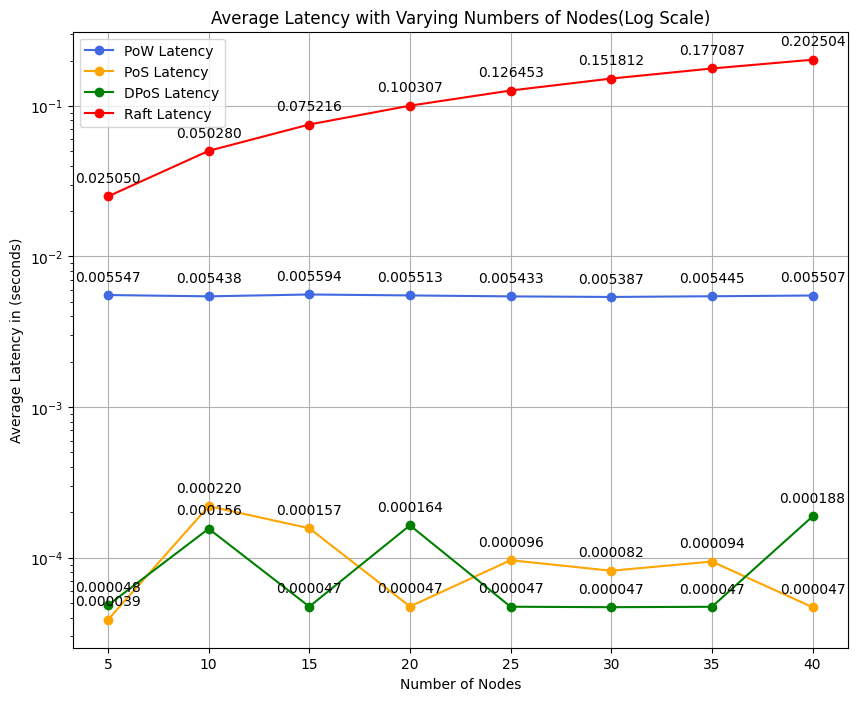

In [112]:
import matplotlib.pyplot as plt
import numpy as np


num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
pow_latencies = {5: 0.005546874523162841, 10: 0.005437691450119018, 15: 0.0055935182571411135, 20: 0.005513352155685425, 25: 0.00543338418006897, 30: 0.005386836051940918, 35: 0.005444554805755615, 40: 0.005507029056549072}
pos_latencies = {5: 3.8748741149902344e-05, 10: 0.0002198927402496338, 15: 0.00015687227249145508, 20: 4.741668701171875e-05, 25: 9.624767303466797e-05, 30: 8.193683624267578e-05, 35: 9.429550170898438e-05, 40: 4.693531990051269e-05}
dpos_latencies = {5: 4.838132858276367e-05, 10: 0.00015578937530517578, 15: 4.736018180847168e-05, 20: 0.000164034366607666, 25: 4.726099967956543e-05, 30: 4.6929121017456057e-05, 35: 4.7220230102539065e-05, 40: 0.00018793201446533204}
raft_latencies = {5: 0.02505048894882202, 10: 0.05028015375137329, 15: 0.07521603417396545, 20: 0.10030747056007386, 25: 0.12645335531234742, 30: 0.15181209754943847, 35: 0.17708705163002014, 40: 0.20250406694412232}


fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')


plt.semilogy(num_nodes, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_nodes, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_nodes, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_nodes, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')


for i, num in enumerate(num_nodes):
    ax.annotate(f'{pow_latencies[num]:.6f}', (num, pow_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{pos_latencies[num]:.6f}', (num, pos_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{dpos_latencies[num]:.6f}', (num, dpos_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{raft_latencies[num]:.6f}', (num, raft_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')


plt.xlabel('Number of Nodes')
plt.ylabel('Average Latency in (seconds)')
plt.title('Average Latency with Varying Numbers of Nodes(Log Scale)')
plt.xticks(num_nodes)


plt.legend()


plt.grid(True)
plt.savefig('Average Latency with Varying Numbers of Nodes Log Scale.png', dpi=300, bbox_inches='tight')
plt.show()
